# Documentación del Script de Enriquecimiento de Grafos RDF

Este script está diseñado para enriquecer nuestro grafo RDF con información adicional obtenida de **DBpedia**. El proceso incluye la normalización de palabras clave, la consulta a DBpedia Spotlight para obtener URIs de recursos, y la extracción de información adicional (etiquetas, comentarios y categorías) mediante consultas SPARQL.

---

## Estructura del Script

### 1. **Namespaces (Espacios de Nombres)**
   - Se definen los namespaces utilizados en el grafo:
     ```
     dbpedia = Namespace("http://dbpedia.org/resource/")
     dbo = Namespace("http://dbpedia.org/ontology/")
     myv = Namespace("http://example.org/myv/")
     schema = Namespace("https://schema.org/")
     ```

---

### 2. **DBpedia Spotlight**
   - Se configura el endpoint de DBpedia Spotlight para obtener URIs de recursos a partir de palabras clave:
     ```
     DBPEDIA_SPOTLIGHT = "https://api.dbpedia-spotlight.org/en/annotate"
     HEADERS = {"Accept": "application/json"}
     ```

---

### 3. **Normalización de Palabras Clave**
   - La función `normalize_keyword` convierte las palabras clave a minúsculas y reemplaza espacios con guiones bajos:
     ```python
     def normalize_keyword(keyword):
         return keyword.lower().replace(" ", "_")
     ```

In [ ]:
# 1
from rdflib import Graph, URIRef, Namespace, Literal, RDF
from rdflib.namespace import SKOS, RDFS, DCTERMS
import requests
import json

# Namespaces
dbpedia = Namespace("http://dbpedia.org/resource/")
dbo = Namespace("http://dbpedia.org/ontology/")
myv = Namespace("http://example.org/myv/")
schema = Namespace("https://schema.org/")

In [ ]:
# DBpedia Spotlight endpoint
DBPEDIA_SPOTLIGHT = "https://api.dbpedia-spotlight.org/en/annotate"
HEADERS = {"Accept": "application/json"}

In [ ]:
# Diccionario de mapeos manuales
manual_mappings = {
    "zero-shot_model": "http://dbpedia.org/resource/Zero-shot_learning",
    "telugu_language": "http://dbpedia.org/resource/Telugu_language",
    "telecom_services": "http://dbpedia.org/resource/Telecommunications_service",
    "nlp": "http://dbpedia.org/resource/Natural_language_processing",
    "openai_chatgpt": "http://dbpedia.org/resource/ChatGPT",
    "python": "http://dbpedia.org/resource/Python_(programming_language)",
    # Agrega más mapeos manuales aquí
}

# Diccionario de sinónimos
synonyms = {
    "zero-shot_model": "zero-shot learning",
    "telugu_language": "Telugu",
    "telecom_services": "telecommunications",
    "nlp": "natural language processing",
    "openai_chatgpt": "ChatGPT",
    "python": "Python programming language",
    # Agrega más sinónimos aquí
}

# Function to normalize keywords
def normalize_keyword(keyword):
    """
    Normalize the keyword by converting it to lowercase and replacing spaces with underscores.
    """
    return keyword.lower().replace(" ", "_")


### DESDE AQUI 

In [ ]:
# Function to query DBpedia Spotlight
def get_dbpedia_uri(keyword):
    """
    Query DBpedia Spotlight to get the URI for a given keyword.
    """
    # Verificar si la palabra clave tiene un mapeo manual
    if keyword in manual_mappings:
        return manual_mappings[keyword]

    # Verificar si la palabra clave tiene un sinónimo
    if keyword in synonyms:
        keyword = synonyms[keyword]

    params = {
        "text": keyword,
        "confidence": 0.5  # Umbral reducido
    }
    try:
        response = requests.get(DBPEDIA_SPOTLIGHT, headers=HEADERS, params=params, timeout=10)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()
        resources = data.get("Resources", [])
        if resources:
            return resources[0]["@URI"]  # Return the first URI found
        else:
            print(f"No resources found for keyword: {keyword}")
    except requests.exceptions.RequestException as e:
        print(f"Error querying DBpedia Spotlight for keyword '{keyword}': {e}")
    return None

In [ ]:
# Function to fetch additional information from DBpedia
def get_dbpedia_info(uri):
    """
    Fetch additional information (labels, comments, and subjects) from DBpedia for a given URI.
    """
    query = """
    SELECT ?prop ?value WHERE {
        VALUES ?uri { <%s> }
        VALUES ?prop { rdfs:label rdfs:comment dcterms:subject }
        ?uri ?prop ?value .
        FILTER(LANG(?value) = "es" || LANG(?value) = "en")
    }
    """ % uri
    sparql_endpoint = "http://dbpedia.org/sparql"
    params = {
        "query": query,
        "format": "json"
    }
    try:
        response = requests.get(sparql_endpoint, params=params, timeout=10)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()
        return [
            (result["prop"]["value"], result["value"]["value"])
            for result in data["results"]["bindings"]
        ]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching DBpedia info for URI '{uri}': {e}")
    return []

In [ ]:
# Load the original RDF file
input_file = "articles_data_cleaned.ttl"
g = Graph()
g.parse(input_file, format="turtle")

# Prepare the enriched graph
enriched_graph = Graph()
enriched_graph.bind("dbo", dbo)
enriched_graph.bind("dbpedia", dbpedia)
enriched_graph.bind("myv", myv)
enriched_graph.bind("skos", SKOS)
enriched_graph.bind("schema", schema)

# Extract unique keywords linked to articles
unique_keywords = set(g.objects(None, DCTERMS.subject))

# Limit processing to the first 20 unique keywords
unique_keywords = list(unique_keywords)[:1000]

# Extract articles for the selected keywords
articles = set()
for keyword_uri in unique_keywords:
    articles.update(g.subjects(DCTERMS.subject, keyword_uri))

In [ ]:

# Process only the articles associated with the selected keywords
for article in articles:
    print(f"Processing article: {article}")

    # Extract keywords linked to the article
    keywords = set(g.objects(article, DCTERMS.subject))

    for keyword_uri in keywords:
        if keyword_uri not in unique_keywords:
            continue  # Skip keywords not in the selected 20

        keyword_label = g.value(keyword_uri, RDFS.label)
        if not keyword_label:
            continue

        keyword = str(keyword_label)
        normalized_keyword = normalize_keyword(keyword)  # Normalize the keyword
        print(f"Processing keyword: {normalized_keyword}")

        # Query DBpedia Spotlight for the keyword
        dbpedia_uri = get_dbpedia_uri(normalized_keyword)
        if dbpedia_uri:
            print(f"Found DBpedia URI: {dbpedia_uri}")

            # Add schema:mentions to the enriched graph
            enriched_graph.add((article, schema.mentions, URIRef(dbpedia_uri)))

            # Fetch additional information for the URI
            info = get_dbpedia_info(dbpedia_uri)
            if info:
                print(f"Additional info found for {dbpedia_uri}: {info}")

                # Add additional information to the enriched graph
                for prop, value in info:
                    if prop == "http://www.w3.org/2000/01/rdf-schema#label":
                        # Normalize the label value
                        normalized_value = normalize_keyword(value)
                        enriched_graph.add((URIRef(dbpedia_uri), RDFS.label, Literal(normalized_value)))
                    elif prop == "http://www.w3.org/2000/01/rdf-schema#comment":
                        # Keep the comment as is
                        enriched_graph.add((URIRef(dbpedia_uri), RDFS.comment, Literal(value)))
                    elif prop == "http://purl.org/dc/terms/subject":
                        enriched_graph.add((URIRef(dbpedia_uri), DCTERMS.subject, URIRef(value)))
            else:
                print(f"No additional info found for URI: {dbpedia_uri}")
        else:
            print(f"No DBpedia URI found for keyword: {normalized_keyword}. Skipping...")

In [ ]:

# Serialize enriched graph to Turtle
output_file = "enriched_articles_data_final.ttl"
enriched_graph.serialize(output_file, format="turtle")
print(f"Enriched data saved to {output_file}")

Processing article: https://schema.org/101109icstsn61422202410671386
Processing keyword: nlp
No DBpedia URI found for keyword: nlp
Processing keyword: social media
No DBpedia URI found for keyword: social media
Processing keyword: deep learning
Found DBpedia URI: http://dbpedia.org/resource/Deep_learning
Additional info found for http://dbpedia.org/resource/Deep_learning: [('http://www.w3.org/2000/01/rdf-schema#label', 'Aprendizaje profundo'), ('http://www.w3.org/2000/01/rdf-schema#comment', 'Aprendizaje profundo (en inglés, deep learning) es un conjunto de algoritmos de aprendizaje automático (en inglés, machine learning) que intenta modelar abstracciones de alto nivel en datos usando arquitecturas computacionales que admiten transformaciones no lineales múltiples e iterativas de datos expresados en forma matricial o tensorial. \u200b'), ('http://www.w3.org/2000/01/rdf-schema#label', 'Deep learning'), ('http://www.w3.org/2000/01/rdf-schema#comment', 'Deep learning (also known as deep 

### Consulta 1: Artículos con sus categorías enriquecidas por DBpedia
```sparql
SELECT ?article ?title ?categoryLabel
WHERE {
    ?article a <https://schema.org/Article> ;
             <https://schema.org/title> ?title ;
             <http://purl.org/dc/terms/subject> ?keywordUri .
    ?keywordUri <http://dbpedia.org/ontology/category> ?categoryUri .
    ?categoryUri <http://www.w3.org/2000/01/rdf-schema#label> ?categoryLabel .
}
LIMIT 10




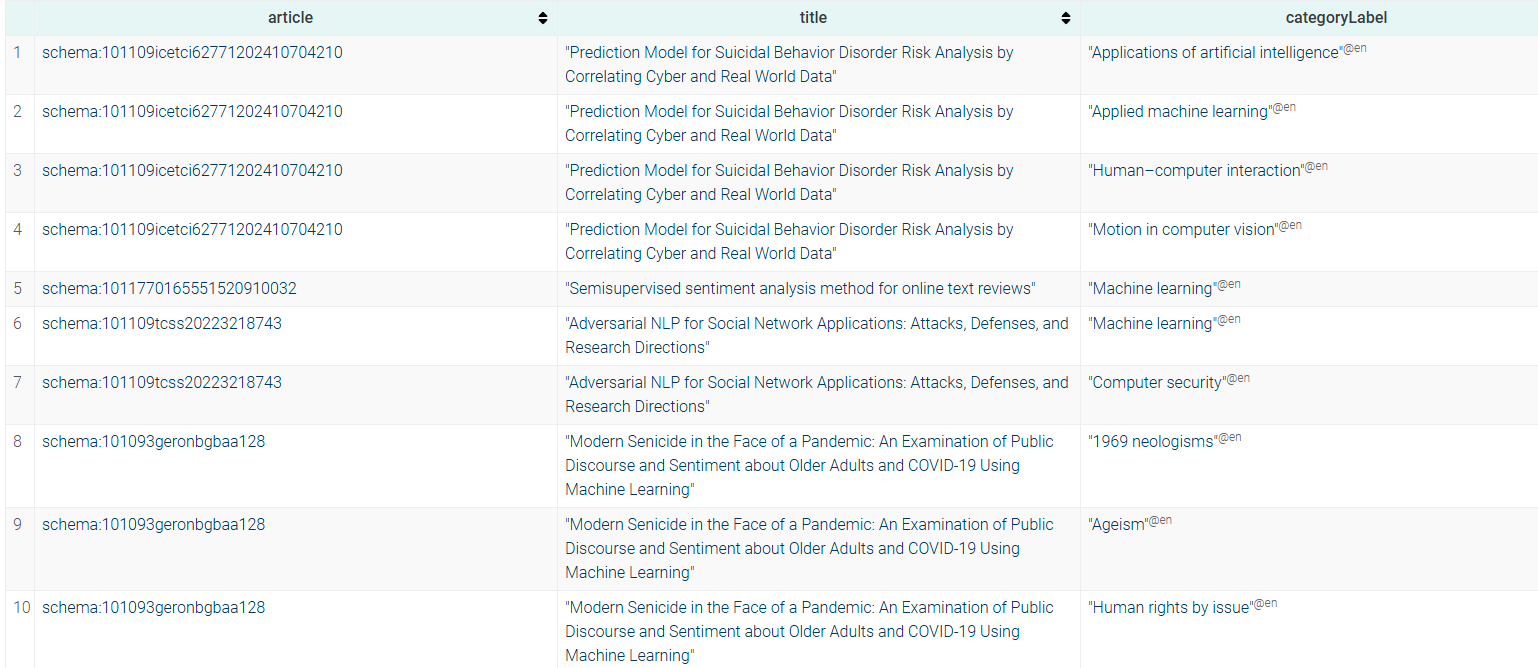

In [11]:
# Retrieve the model as the reference for transformation
from IPython.display import Image

# Specify the path to your image file
image_path = 'con1.png'

# Display the image
Image(filename=image_path)

### Consulta 2: Artículos y categorías enriquecidas por DBpedia
```sparql
SELECT ?article ?title ?category ?categoryLabel
WHERE {
    ?article a <https://schema.org/Article> ;
             <https://schema.org/title> ?title ;
             <http://purl.org/dc/terms/subject> ?keyword .
    ?keyword <http://dbpedia.org/ontology/category> ?category .
    ?category <http://www.w3.org/2000/01/rdf-schema#label> ?categoryLabel .
}
ORDER BY ?title
LIMIT 20

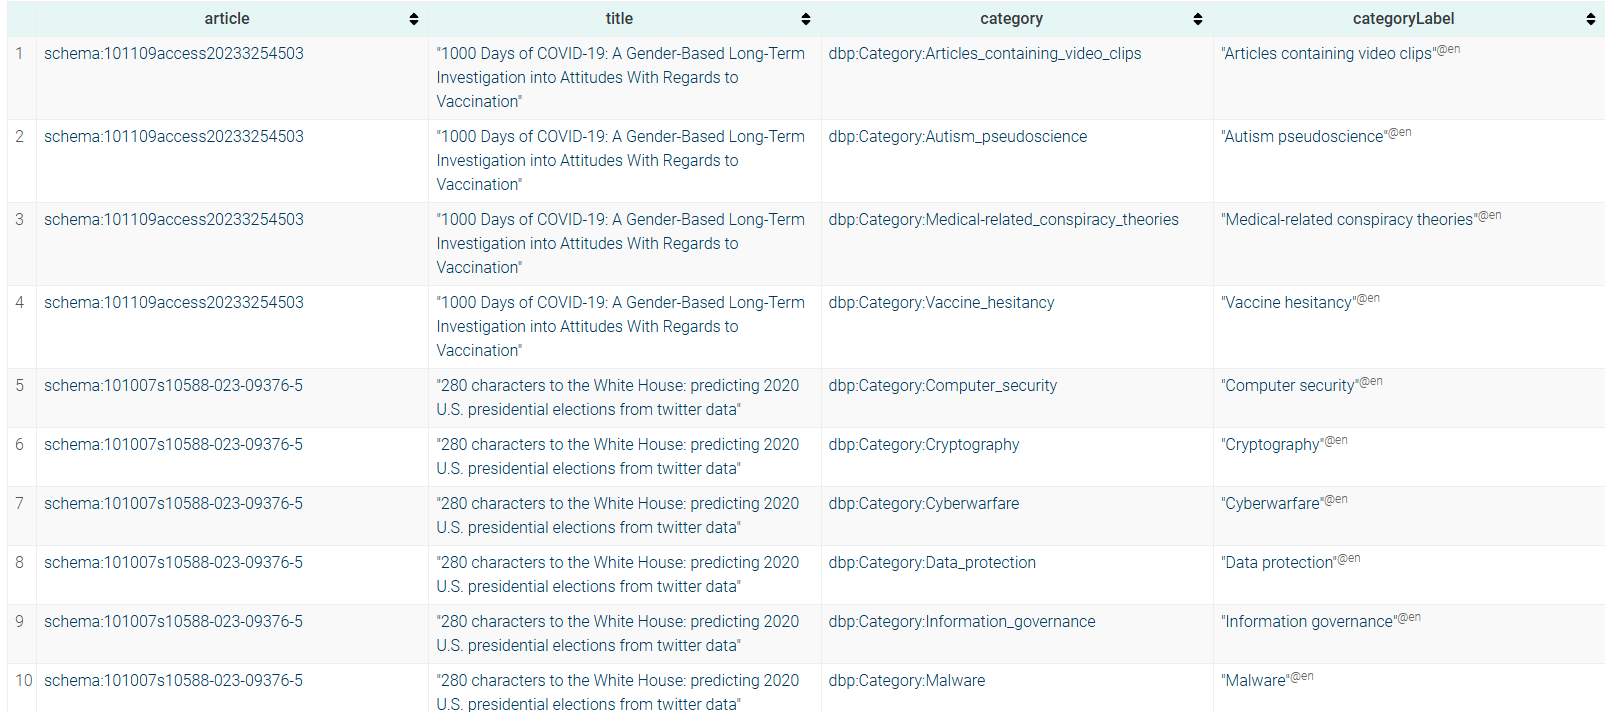

In [12]:

# Specify the path to your image file
image_path = 'con2.png'

# Display the image
Image(filename=image_path)

### Consulta 3: Observaciones relacionadas con citas entre artículos
```sparql
SELECT ?source ?sourceTitle ?target ?targetTitle ?description
WHERE {
    ?observation a <http://example.org/myv/Observation> ;
                 <https://schema.org/citation> ?source ;
                 <https://schema.org/citation> ?target .
    ?source <https://schema.org/title> ?sourceTitle ;
            <https://schema.org/description> ?description .
    ?target <https://schema.org/title> ?targetTitle .
}
LIMIT 10

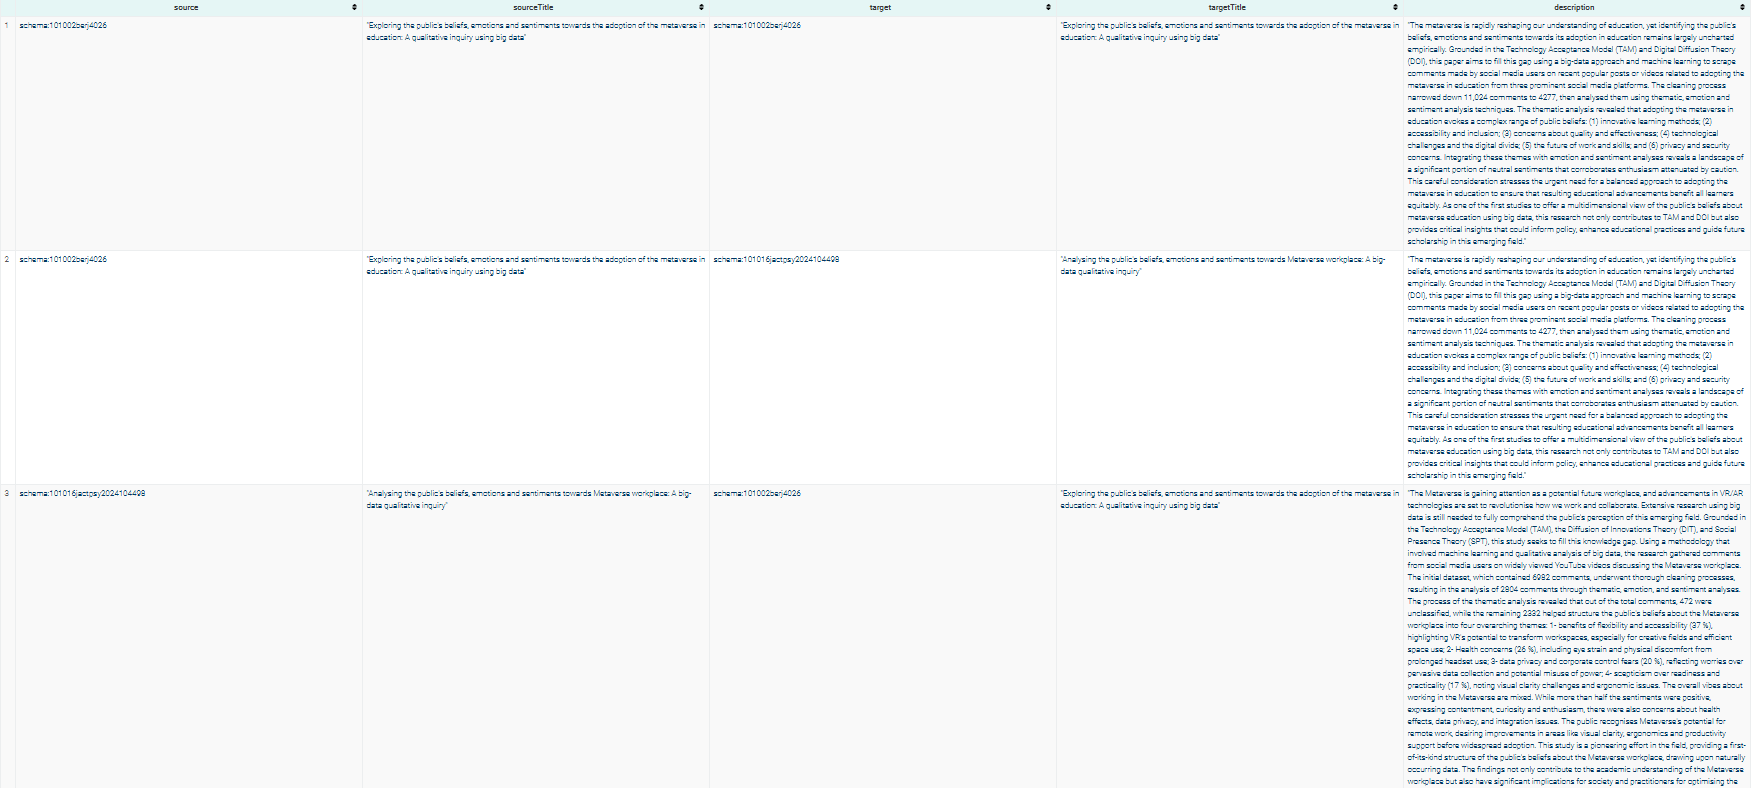

In [13]:

# Specify the path to your image file
image_path = 'con3.png'

# Display the image
Image(filename=image_path)

### Consulta 4: Artículos con sus títulos, fechas de publicación y nombres de autores ordenados por fecha
```sparql
SELECT ?article ?title ?datePublished ?authorName
WHERE {
    ?article a <https://schema.org/Article> ;
             <https://schema.org/title> ?title ;
             <https://schema.org/datePublished> ?datePublished ;
             <https://schema.org/author> ?author .
    ?author <https://schema.org/name> ?authorName .
}
ORDER BY DESC(?datePublished)
LIMIT 10


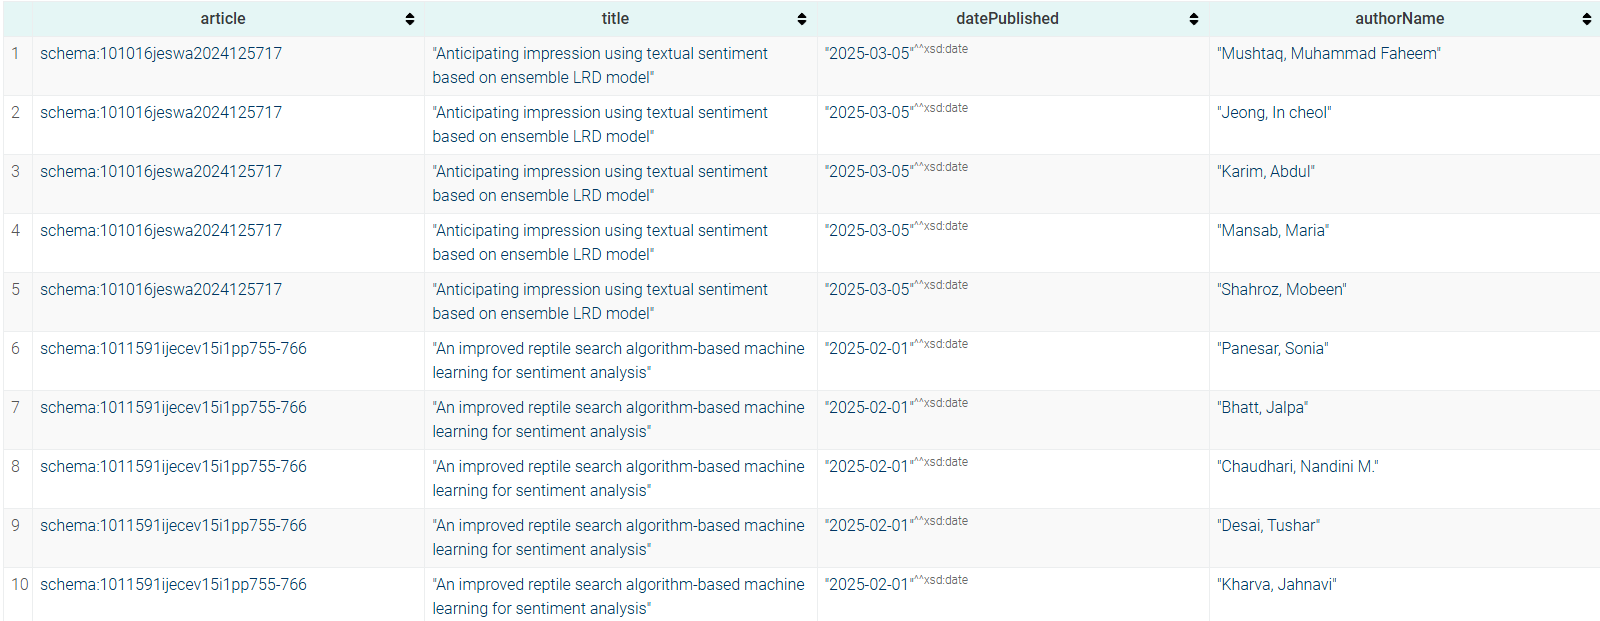

In [14]:

# Specify the path to your image file
image_path = 'con4.png'

# Display the image
Image(filename=image_path)

### Consulta 5: Artículos con más coautores y sus categorías principales
```sparql
SELECT ?article ?title (COUNT(DISTINCT ?author) AS ?coauthorCount) ?mainCategory ?mainCategoryLabel
WHERE {
    ?article a <https://schema.org/Article> ;
             <https://schema.org/title> ?title ;
             <http://purl.org/dc/terms/subject> ?category ;
             <https://schema.org/author> ?author .
    ?category <http://www.w3.org/2000/01/rdf-schema#label> ?categoryLabel .
    # Relacionamos la categoría más común
    {
        SELECT ?article (SAMPLE(?category) AS ?mainCategory) (SAMPLE(?categoryLabel) AS ?mainCategoryLabel)
        WHERE {
            ?article <http://purl.org/dc/terms/subject> ?category .
            ?category <http://www.w3.org/2000/01/rdf-schema#label> ?categoryLabel .
        }
        GROUP BY ?article
    }
}
GROUP BY ?article ?title ?mainCategory ?mainCategoryLabel
HAVING (COUNT(DISTINCT ?author) > 5) # Solo artículos con más de 5 coautores
ORDER BY DESC(?coauthorCount)
LIMIT 10


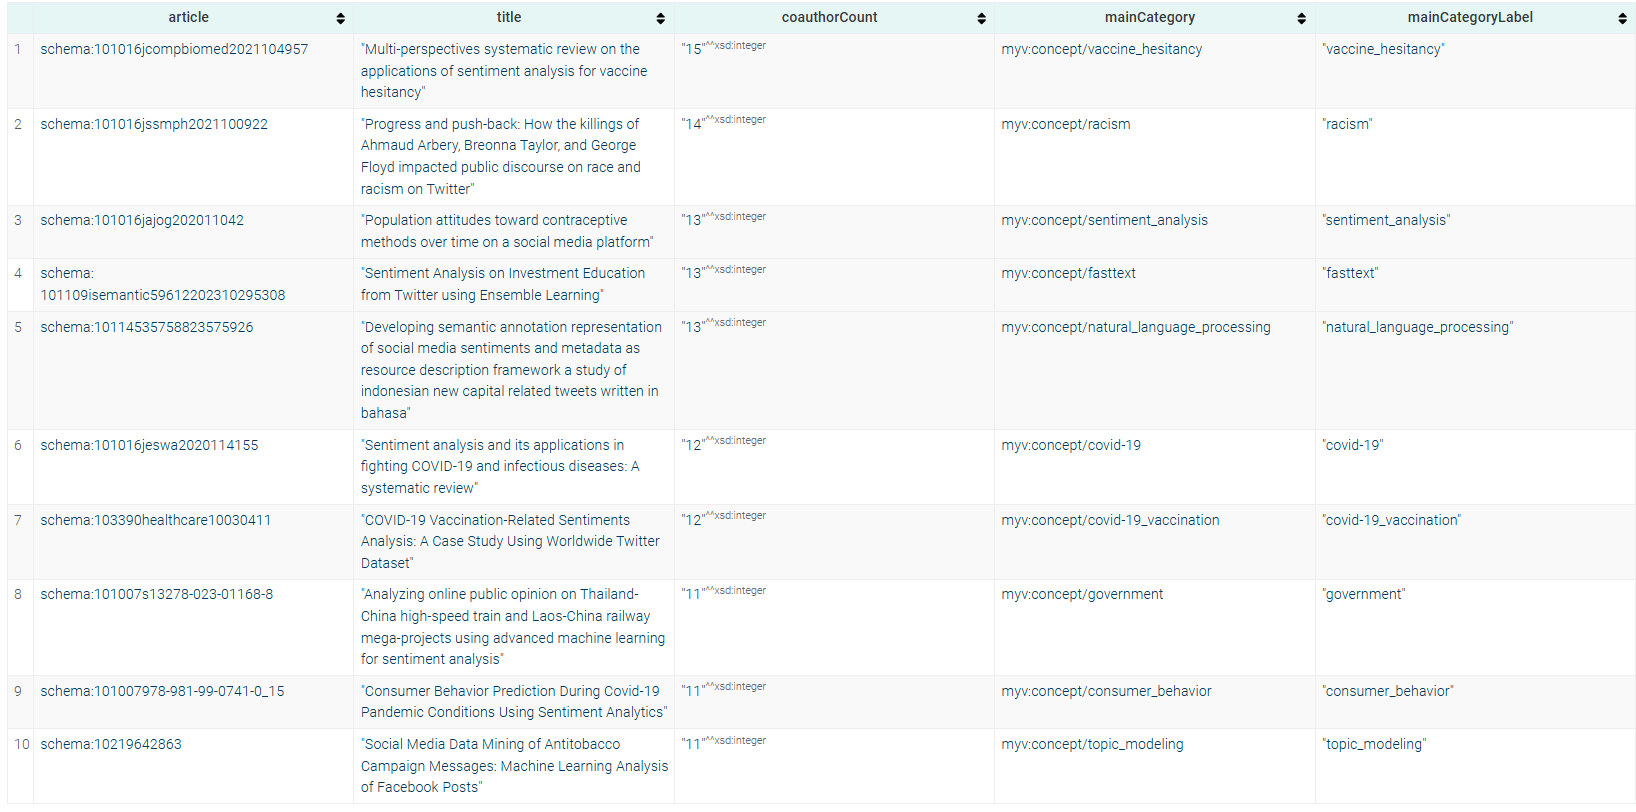

In [15]:

# Specify the path to your image file
image_path = 'con5.png'

# Display the image
Image(filename=image_path)

## Capturas Modelo de Grafo final

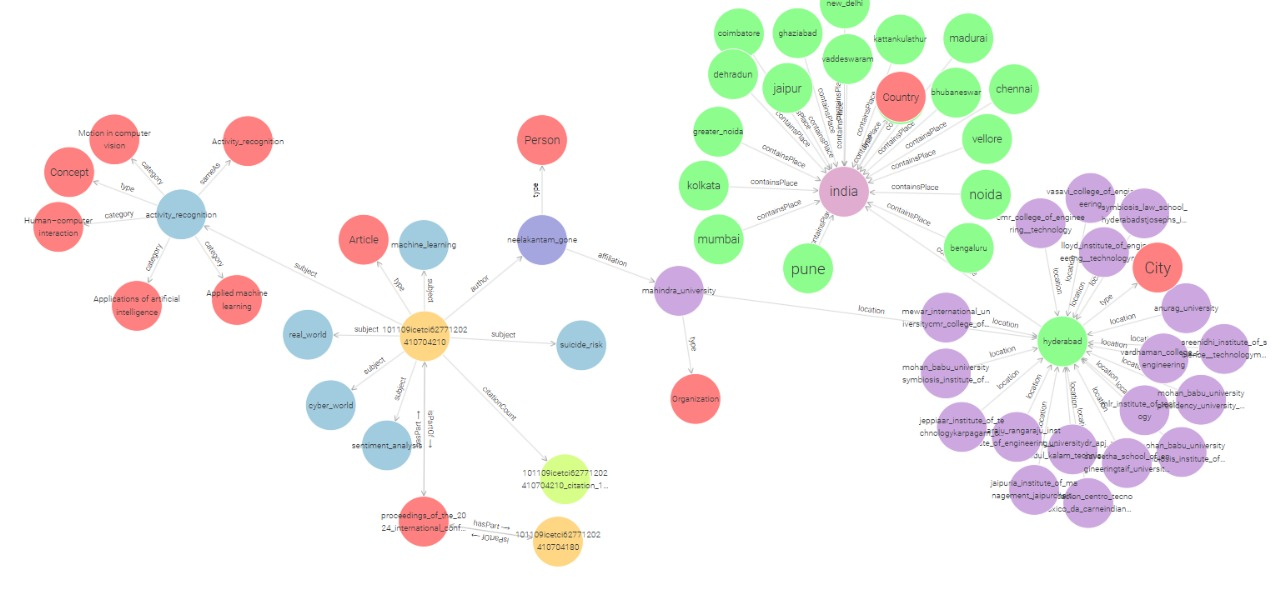

In [18]:

# Specify the path to your image file
image_path = 'Graph1.jpg'

# Display the image
Image(filename=image_path)

In [19]:
!jupyter nbconvert --to html enrequecimiento.ipynb

[NbConvertApp] Converting notebook enrequecimiento.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1490355 bytes to enrequecimiento.html
